In [2]:
%run modulo-adder.ipynb

done


In [3]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import QFT
from math import log, ceil, floor, pi

def c_mod_mul(a, N, x, n_b_qubits):
    n_x_bits = floor(log(x, 2)) + 1
    c_mod_mul_circ = QuantumCircuit(
        QuantumRegister(1, name="control"),
        QuantumRegister(n_b_qubits, name="x"),
        QuantumRegister(n_b_qubits, name="b"),
        QuantumRegister(1, name="ancilla")
    )
    c_mod_mul_circ.append(
        QFT(n_b_qubits, do_swaps=False).to_gate(), 
        [i + n_b_qubits + 1 for i in range(n_b_qubits)]
    )
    for i in range(n_x_bits):
        allocs = [i + n_b_qubits + 1 - 2 for i in range(n_b_qubits + 3)]
        allocs[0] = 0
        allocs[1] = i + 1
        a_pow = (a << i) % N
        c_mod_mul_circ.append(
            c2_qft_mod_adder(a_pow, N, n_b_qubits).to_gate(label=f"\Phi ADD({a_pow})MOD({N}))"),
            allocs
        )
    c_mod_mul_circ.append(
        QFT(n_b_qubits, do_swaps=False, inverse=True).to_gate(), 
        [i + n_b_qubits + 1 for i in range(n_b_qubits)]
    )
    return c_mod_mul_circ

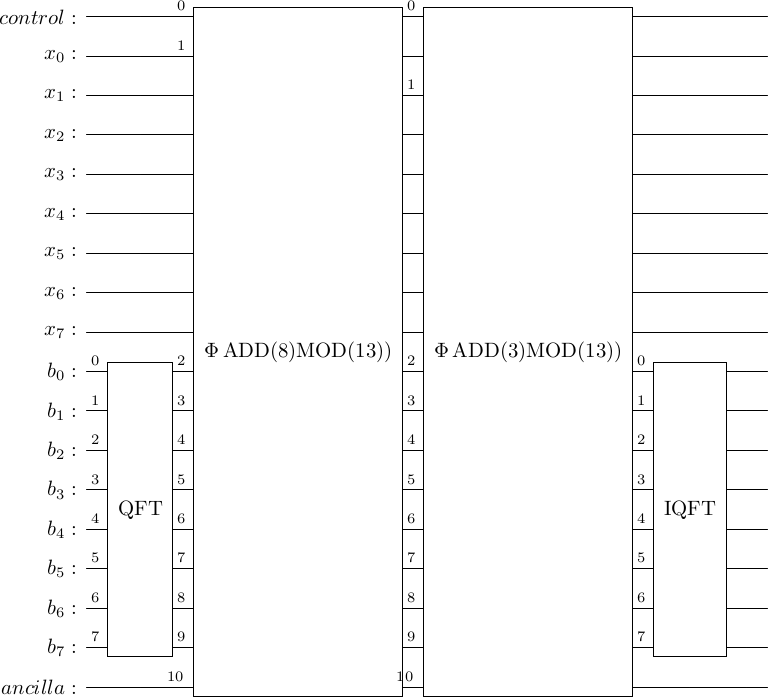

In [4]:
a = 8
x = 7
b = 0
N = 13
n_req = floor(log(N, 2)) + 1
a_req = max(floor(log(a, 2)) + 1, floor(log(x, 2)) + 1)
n_qubits = n_req + a_req
n_b_qubits = n_qubits
n_x_qubits = floor(log(x, 2)) + 1
c_mod_mul(a, N, n_x_qubits, n_b_qubits).draw("latex")

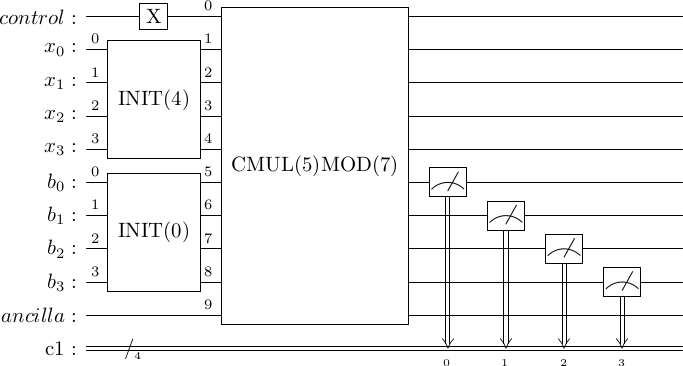

In [10]:
a = 5
x = 4
b = 0
N = 7
n_req = floor(log(N, 2)) + 1
n_qubits = n_req + 1
n_b_qubits = n_qubits

test_circuit = QuantumCircuit(
    QuantumRegister(1, name="control"),
    QuantumRegister(n_b_qubits, name="x"),
    QuantumRegister(n_b_qubits, name="b"),
    QuantumRegister(1, name="ancilla"),
    ClassicalRegister(n_b_qubits)
)
test_circuit.x(0)
test_circuit.append(
    init_x_circuit(x, n_b_qubits, msb_top=False).to_gate(label=f"INIT({x})"), 
    [i + 1 for i in range(n_b_qubits)]
)
test_circuit.append(
    init_x_circuit(b, n_b_qubits, msb_top=False).to_gate(label=f"INIT({b})"),
    [i + 1 + n_b_qubits for i in range(n_b_qubits)]
)
test_circuit.append(
    c_mod_mul(a, N, x, n_b_qubits).to_gate(label=f"CMUL({a})MOD({N})"),
    range(1 + n_b_qubits + n_b_qubits + 1)
)
test_circuit.measure(range(1 + n_b_qubits , 1 + n_b_qubits + n_b_qubits), range(n_b_qubits))
test_circuit.draw("latex")

In [11]:
from qiskit.providers.aer import QasmSimulator
from qiskit import transpile

""" Simulation """
# Create a simulator
simulator = QasmSimulator()
# Compile the circuit for the simulator
compiled_circuit = transpile(test_circuit, simulator)
# Simulate the circuit
simulation = simulator.run(compiled_circuit, shots=1)
# Get the simulation results
simulation_result = simulation.result()
counts = simulation_result.get_counts(compiled_circuit)
counts

{'0110': 1}